In [1]:
# coding: utf-8

# In[ ]:
import sys, os        
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
import numpy as np
import time
from nips2016 import humantraffic
from tensorflow.python import debug as tf_debug
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
np.random.seed(2017) 
# notification
sys.path.insert(0, '../../')


# 配置显存大小
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.4)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)

# In[ ]:

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

In [2]:
from CoreUtils.SendNotification import send_notification
from CoreUtils import SendNotification
# SendNotification.http_config = '101.5.97.134'
SendNotification.http_config = '192.168.34.138'
# print()

In [3]:
print('current path is {0}'.format(os.getcwd()))

current path is /home/csi/Git/HumanFlowPrediction/cnn_graph/nips2016


In [4]:
# In[ ]:
def sparse_matrix_element_wise_max(A, B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(20, corners=False)
# A = graph.replace_random_edges(A, 0)
# graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True)] # [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
# graph.plot_spectrum(L)
# del A

1646 > 1600 edges
Execution time: 0.10s


In [5]:
# experiment init
# DATA_SET_PATH='../../data/lndata'
# DATA_SET_PATH='../../data/lndata_filter'
DATA_SET_PATH='../../data/lndata_street'
#DATA_SET_PATH='../../data/bjtaxi'
# DATA_SET_PATH='../../data/shanxidata'
seq_num = 4
t_start = time.process_time()
ht = humantraffic.HumanTraffic(DATA_SET_PATH)
# train_data, val_data, test_data, train_labels, val_labels, test_labels, A1 = ht.load_bj_data(seq_num)
train_data, val_data, test_data, train_labels, val_labels, test_labels, A1 = ht.load_split_ln_data_period(seq_num)
# train_data, val_data, test_data, train_labels, val_labels, test_labels, A1 = ht.load_split_ln_data(seq_num)
A1 = A1.astype(np.float32)
# A = sparse_matrix_element_wise_max(A, A1)
# A = A.astype(np.float32)
L = [graph.laplacian(A1, normalized=True)] # [graph.laplacian(A, normalized=True) for A in graphs]
#del A
train_data_ = np.zeros((train_data.shape[0], train_data.shape[1], train_data.shape[2]))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
print('train_data shape: ', train_data.shape)

shape of data_samples: 1487
Execution time: 0.10s
train_data shape:  (1115, 104, 20)


(1115, 104, 2)


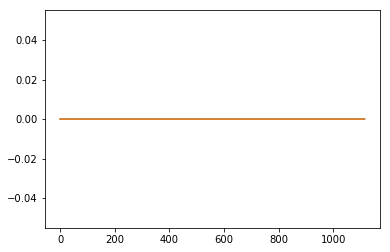

In [6]:
print(train_labels.shape)
plt.plot(train_labels[:, 69])

In [ ]:
# In[ ]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 100
common['batch_size']     = 100
common['decay_steps']    = train_data.shape[0] / common['batch_size']
common['eval_frequency'] = 100
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
# C = max(mnist.train.labels) + 1  # number of classes
model_perf = utils.model_perf()
print(train_data.shape)
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.04
common['decay_rate']     = 0.9
common['momentum']       = 0.9
common['F']              = [10]
common['K']              = [20]
common['p']              = [1]
common['M']              = [train_data.shape[1]]

(1115, 104, 20)


In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 32
    params['_nres_layer_count'] = 3
    params['K'] = [20]
    params['_STACK_NUM'] = 1
    params['C_0'] = train_data.shape[2]
    params['model_name'] = 'ResGNN'
    # params['model_name'] = 'GNN'
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    s1 = str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2])))
    s2 = str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2])))
    print (s1 + ' ' + s2)
    print('train finish...\n') 

    send_notification('cnn_graph finished part 1', 'cnn_grpah')

NN architecture
  input: M_0 = 104
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 104 * 10 / 1 = 1040
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 104
    weights: M_1 * M_2 = 1040 * 104 = 108160
    biases: M_2 = 104
dict_keys(['conv_init/weights:0', 'conv_init/filter/transpose_2:0', 'conv_init/activation/Relu:0', 'residual_layer_0/sublayer0/weights:0', 'residual_layer_0/sublayer1/weights:0', 'residual_layer_0/sublayer1/activation2/Relu:0', 'residual_layer_1/sublayer0/weights:0', 'residual_layer_1/sublayer1/weights:0', 'residual_layer_1/sublayer1/activation2/Relu:0', 'residual_layer_2/sublayer0/weights:0', 'residual_layer_2/sublayer1/weights:0', 'residual_layer_2/sublayer1/activation2/Relu:0', 'convN/weights:0', 'convN/filter/transpose_2:0'])
step 100 / 1115 (epoch 8.97 / 100):
  learning_rate = 1.72e-02, loss_average = 1.45e-04
  validation mse: 0.00014 ( 185), f1 (weighted), loss: 1.36e-04
  tim

In [ ]:
# In[ ]:

if True:
                     
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 64
    params['_nres_layer_count'] = 4
    params['K'] = [20]
    params['C_0'] = seq_num * 2              
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 6
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 8
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 10
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 12
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 14
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 16
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 18
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
# In[ ]:

if True:
    
    # sess = tf.Session(config=config)
    start_time = time.time()
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'fourier'
    params['_nfilter'] = 24
    params['_nres_layer_count'] = 20
    params['K'] = [20]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    end_time = time.time()
    print("total time {0} elapse...\n".format(end_time - start_time))
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    # send_notification('cnn_graph finished part 1', 'cnn_grpah')

In [ ]:
%%javascript
Jupyter.notebook.config.update({"load_extensions":{"notify":true}})
Jupyter.notebook.config.update({"load_extensions":{"theme_toggle":true}})

In [ ]:
if True:
    name = 'spline_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'spline'
    params['K'] = [10]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    send_notification('cnn_graph finished part 2', 'cnn_grpah')

In [ ]:
if True:
    
    name = 'chebyshev_softmax'
    params = common.copy()
    params['dir_name'] += name
    #params['filter'] = 'chebyshev2' # fourier
    params['filter'] = 'chebyshev5'
    params['K'] = [5]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')
    send_notification('cnn_graph finished part 3', 'cnn_grpah')

In [ ]:
print(train_data.shape)
print(val_labels.shape)

In [ ]:
print(train_pred.shape)

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.plot(train_target[:, 68, 1])
plt.plot(train_pred[:, 68, 1])

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.plot(test_target[:, 68, 1])
plt.plot(test_pred[:, 68, 1])